In [1]:
#import the tree parser
import baltic_four as bt

#load other relevant libraries for plotting
import numpy as np
print np.__version__
import re
from scipy.special import binom
import matplotlib as mpl
import matplotlib.pyplot as plt
print mpl.__version__
%matplotlib inline

from matplotlib import font_manager as fm
fm.findfont('Helvetica')

1.11.2
1.5.1


u'/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'

## First step: parse the mcc trees using baltic (by Gytis Dudas)

The baltic tree parser will iterate though the tree recording instances of the leaves and nodes.

In [2]:
tree_path='/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/usvi-primary-clade.mcc'
print "File: %s"%(tree_path.split('/')[-1]) #make sure I have the right file

File: usvi-primary-clade.mcc


In [3]:
tipFlag=False ## used to keep track of where we are in FigTree format
tips={} ## dictionary of tip code to full tip name

for line in open(tree_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    if tip_count_match is not None:
        tipNum=int(tip_count_match.group(1)) 

print tipNum #should be the total number of taxa in the tree.

19


In [4]:
for line in open(tree_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree TREE([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        linked_list = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],linked_list) ## send tree string to make_tree function, provide an empty tree object

In [5]:
for line in open(tree_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        if tip_match is not None:
            tips[tip_match.group(1)]=tip_match.group(2).strip("'") 
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in tree string: %d"%(len(linked_list.Objects))

Number of objects found in tree string: 37


In [6]:
if len(tips)==0: ## use this if tip names in the string are already the final format
    for k in linked_list.Objects:
        if isinstance(k,leaf):
            k.name=k.numName
    highestTip=max([bt.decimalDate(x.name.strip("'").split('|')[2],variable=True) for x in linked_list.Objects if isinstance(x,leaf)])
else: ## there's a tip name map at the beginning, so translate the names (so that you're not using the taxon numbers)
    linked_list.renameTips(tips) ## give each tip a name
    highestTip=max([bt.decimalDate(x.strip("'").split('|')[2],variable=True) for x in tips.values()])
print highestTip

linked_list.sortBranches(descending=False) #sorts branches and automatically draws tree.

linked_list.setAbsoluteTime(highestTip) #set absolute time based off of most recent leaf.
print 'Highest tip date: %.4f'%(highestTip) #and check that that's correct.

2016.85519126
Highest tip date: 2016.8552


In [101]:
#designate which font to use. To use others just use different ttf files 
#if ttf files not already in there, may need to do fondu conversion of dfont files and move in.
font_path = '/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeueThin.ttf'
font_properties = fm.FontProperties(fname=font_path)
print font_properties
mpl.rcParams['font.family'] = font_properties.get_name()

#designate some font characteristics
mpl.rcParams['font.weight']=100
mpl.rcParams['axes.labelweight']=100
mpl.rcParams['font.size']=14


:family=Helvetica,HelveticaNeue,HelveticaLight,sans-serif:style=normal:variant=normal:weight=400:stretch=normal:file=/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeueThin.ttf:size=10.0


In [114]:
### designate some nodes in the tree to show support values for ###
#tips is the dictionary I have linking numNames to realNames.

#linked list is my tree object
#tipMap is a method of tree objects. 
linked_list.tipMap=tips

#commonAncestor is also a method of tree objects, takes a list
#note you can specify whether the list is of numNames or actual names.
#default is numNames = FALSE, here I'm making that explicit.
stt_support = linked_list.commonAncestor(['USVI/25/2016|VI25|2016-09-27|usvi|saint_thomas|saint_thomas|minion','USVI/35/2016|VI35|2016-09-08|usvi|saint_thomas|saint_thomas|minion'],False)
stt_sub_clade = linked_list.commonAncestor(['USVI/25/2016|VI25|2016-09-27|usvi|saint_thomas|saint_thomas|minion','USVI/38/2016|VI38|2016-10-25|usvi|saint_thomas|saint_thomas|minion'],False)
stj_support = linked_list.commonAncestor(['USVI/21/2016|VI21|2016-11-07|usvi|saint_john|saint_john|minion','USVI/6/2016|VI6|2016-10-19|usvi|saint_john|saint_john|miseq'],False)
stx_support = linked_list.commonAncestor(['USVI/37/2016|VI37|2016-10-06|usvi|saint_croix|saint_croix|minion','USVI/39/2016|VI39|2016-11-09|usvi|saint_croix|saint_croix|minion'],False)
stx_stt_support = linked_list.commonAncestor(['USVI/37/2016|VI37|2016-10-06|usvi|saint_croix|saint_croix|minion','USVI/23/2016|VI23|2016-07-12|usvi|saint_thomas|saint_thomas|minion'],False)

In [116]:
#make node string for annotating support values on tree figure.

stt_support_val = '{0:.2f}'.format(stt_support.traits['posterior'])
stt_sub_clade_val = '{0:.2f}'.format(stt_sub_clade.traits['posterior'])
stj_support_val = '{0:.2f}'.format(stj_support.traits['posterior'])
stx_support_val = '{0:.2f}'.format(stx_support.traits['posterior'])
stx_stt_support_val = '{0:.2f}'.format(stx_stt_support.traits['posterior'])

print stt_support_val
print stt_sub_clade_val
print stj_support_val
print stx_support_val
print stx_stt_support_val

0.67
1.00
1.00
0.95
0.99


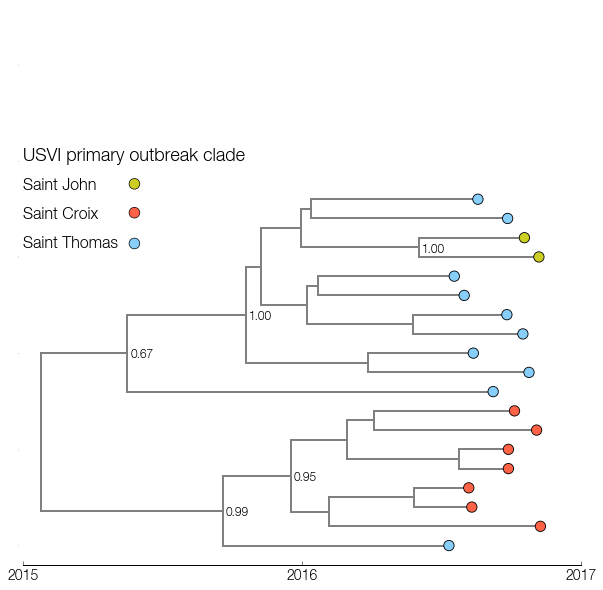

In [143]:
####### tree drawing #######

linked_list.sortBranches(descending=False)
#set plotting parameters and plotting area
fig,ax = plt.subplots(figsize=(10,10),facecolor='white')
branchWidth=2 ## default branch width

# iterate over the branches
# x and y relate to dimensions when plotting, x is based on sampling date, y is arbitrary
# and just allows expansion of the tree at even widths (y coords not informative in a tree)
# each node in the tree (internal and leaves) will have an (x,y) coordinate.
for k in linked_list.Objects:
    x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    #c= 'blue' #color can be fixed across trait
    #or color can be applied by traits
    #color = cmap(k.height/linked_list.treeHeight)
    
    ##### colour setting #####
    #SET NODE COLOURS BASED ON ISLAND OF SAMPLING
    if k.branchType == 'leaf' and k.name.split('|')[4] == 'saint_thomas':
        color = 'lightskyblue' #a real matplotlib colour!
    elif k.branchType == 'leaf' and k.name.split('|')[4] == 'saint_croix':
        color = 'tomato'
    elif k.branchType == 'leaf' and k.name.split('|')[4] == 'saint_john':
        color = '#ccce23'


    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        s=90 ## tip size can be fixed
        #s=50-30*k.height/linked_list.treeHeight #or size can be relative
        
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.4*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color='grey',ls='-',zorder=9)
        #draw a circle on a specific node and annotate

        ####### Add posterior support for key nodes #######        
        if k == stt_support:
            ax.text(x+0.01,y-0.25,stt_support_val,size=12)
        elif k == stt_sub_clade:
            ax.text(x+0.01,y-0.25,stt_sub_clade_val,size=12)
        elif k == stj_support:
            ax.text(x+0.01,y-0.25,stj_support_val,size=12)
        elif k == stx_support:
            ax.text(x+0.01,y-0.25,stx_support_val,size=12)
        elif k == stx_stt_support:
            ax.text(x+0.01,y-0.25,stx_stt_support_val,size=12)
    
    #plot the rest of the branches   
    ax.plot([xp,x],[y,y],lw=branchWidth,color='grey',ls='-',zorder=9) #branches should be plotted beneath tip circles.


    
####### Plot area formatting #########
#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='top',labelsize=0,size=0)

#make the x labels plot in years

ax.xaxis.set_ticks_position('bottom')   
ax.set_xticks(range(2015,2018))
ax.set_xticklabels(range(2015,2018))

ax.set_xlim(2015,2017)
ax.set_ylim(-1,len(linked_list.Objects)/2+10)


######## make legend #########
ax.text(2015,20, 'USVI primary outbreak clade', size=18)
ax.text(2015,18.5, 'Saint John', size=16)
ax.text(2015,17, 'Saint Croix', size=16)
ax.text(2015,15.5, 'Saint Thomas', size=16)

#STJ
ax.scatter(2015.4,18.8,s=100,facecolor='#ccce23',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(2015.4,18.8,s=130,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
#STX
ax.scatter(2015.4,17.3,s=100,facecolor='tomato',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(2015.4,17.3,s=130,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
#STT
ax.scatter(2015.4,15.7,s=100,facecolor='lightskyblue',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(2015.4,15.7,s=130,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath

####### see the plot #######
plt.show()
plt.figure()
fig.savefig('usvi-primary-clade.pdf')
fig.savefig('usvi-primary-clade.png')